# Dataset Preparation

### Importing of libraries

In [181]:
import pandas as pd
import os
import pickle

import collections
from vocab import Vocab, Vectors
from wordebd import WORDEBD

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

### Importing of data

In [182]:
dataset_path = "dataset_drop_noise"

# Read the CSV file
TrainData = pd.read_csv('data/dataset_original/NOT_FOR_TRAINING/train_sent_emo_dya.csv', encoding='shift_jis')
TestData = pd.read_csv('data/dataset_original/NOT_FOR_TRAINING/test_sent_emo_dya.csv', encoding='utf-8')
DevData = pd.read_csv('data/dataset_original/NOT_FOR_TRAINING/dev_sent_emo_dya.csv', encoding='utf-8')

# Display the first three rows
print(TrainData.shape)
print(TestData.shape)
print(DevData.shape)


(12840, 12)
(3400, 12)
(1462, 12)


### Dropping of Features

Drop Old_Dialogue_ID, Old_Utterance_ID, Season, Episode, StartTime, and EndTime

In [183]:
# Define features to drop
drop_features = list(TrainData.columns[6:]) 
drop_features

['Old_Dialogue_ID',
 'Old_Utterance_ID',
 'Season',
 'Episode',
 'StartTime',
 'EndTime']

In [184]:
# Drop features from X_train DataFrame
TrainData = TrainData.drop(drop_features, axis=1)
TestData = TestData.drop(drop_features, axis=1)
DevData = DevData.drop(drop_features, axis=1)

In [185]:
key = True

checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/label_decoder.pkl")

if not (checkFile1 and checkFile2):
    labels = sorted(set(TrainData.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/' + dataset_path + '/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/' + dataset_path + '/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/' + dataset_path + '/label_encoder.pkl', 'rb')
    file2 = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [186]:
labelEncoder

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [187]:
def encode_labels(encoder, l):
    return encoder[l]

In [188]:
# Apply label encoding to the "Emotion" column in y_train
TrainData["Emotion"] = TrainData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
TestData["Emotion"] = TestData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
DevData["Emotion"] = DevData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))

In [189]:
def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

In [190]:
rangesTrain = find_value_ranges(TrainData["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(TestData["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(DevData["Dialogue_ID"])
print(len(rangesDev))

2160
577
270


### Copying orginal dataset

This section will copy the current dataframe to be ready for export and stored at dataset_original since dataset_original will NOT have any pre-processing of utterances. 

In [191]:
TrainData_Original =  TrainData
TestData_Original = TestData
DevData_Original = DevData

### Data Pre-Processing

In [192]:
# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Make a copy of X_train_utterances
train_utterances = TrainData['Utterance']
test_utterances = TestData['Utterance']
dev_utterances = DevData['Utterance']

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()

custom_stop_words = set([
    'a', 'an', 'the', 'and', 'but', 'or', 'nor', 'for', 'yet', 'so',
    'at', 'by', 'for', 'in', 'of', 'on', 'to', 'with', 'about', 'above',
    'across', 'after', 'against', 'along', 'among', 'around', 'as', 'before',
    'behind', 'below', 'beneath', 'beside', 'between', 'beyond', 'during',
    'except', 'from', 'inside', 'into', 'near', 'outside', 'over', 'through',
    'under', 'until', 'up', 'upon', 'within', 'without', 'I', 'me', 'my',
    'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'get',
    'go', 'make', 'take', 'want', 'know', 'see', 'come', 'think', 'look',
    'use', 'find', 'give', 'tell', 'work', 'call', 'try', 'ask', 'need',
    'feel', 'become', 'leave', 'put', 'mean', 'keep', 'let', 'begin',
    'seem', 'help', 'talk', 'turn', 'start', 'show', 'hear', 'play', 'run',
    'move', 'like', 'live', 'believe', 'hold', 'bring', 'happen', 'write',
    'provide', 'sit', 'stand', 'lose', 'pay', 'meet', 'include', 'continue',
    'set', 'learn', 'change', 'lead', 'understand', 'watch', 'follow',
    'stop', 'create', 'speak', 'read', 'allow', 'add', 'spend', 'grow',
    'open', 'walk', 'win', 'offer', 'remember', 'love', 'consider',
    'appear', 'buy', 'serve', 'die', 'send', 'expect', 'build', 'stay',
    'fall', 'cut', 'reach', 'kill', 'remain', 'suggest', 'raise', 'pass',
    'sell', 'require', 'report', 'decide', 'pull', 'become', 'very',
    'really', 'too', 'quite', 'much', 'so', 'just', 'even', 'now', 'then',
    'here', 'there', 'when', 'where', 'why', 'how', 'well', 'also', 'such',
    'still', 'only', 'always', 'never', 'ever', 'often', 'usually',
    'sometimes', 'once', 'this', 'that', 'these', 'those', 'each', 'every',
    'all', 'some', 'any', 'both', 'few', 'many', 'much', 'more', 'most',
    'other', 'another', 'such', 'same', 'own', 'what', 'which', 'either',
    'neither', 'not', 'no', "n't", 'nor', 'oh', 'ah', 'uh', 'um'
])

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [193]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)

    # Remove punctuation and non-alphabetic characters, and stop words
    words = [word for word in words if word.isalpha() and word not in custom_stop_words]

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text


# Apply the clean_text function to each utterance
train_utterances = train_utterances.apply(clean_text)
test_utterances = test_utterances.apply(clean_text)
dev_utterances = dev_utterances.apply(clean_text)

In [194]:
train_utterances.head()

0    i point person company s transition system
1                             must ve hand full
2                                           i i
3                             s little bit duty
4                                    duty right
Name: Utterance, dtype: object

In [195]:
test_utterances.head()

0                          re coffee mug number bottom
1    s monica can track way if one missing can s nu...
2                                                     
3                                                 okay
4                                    ross say elevator
Name: Utterance, dtype: object

In [196]:
dev_utterances.head()

0              god s lost s totally lost
1                                       
2    could bank close account off source
3                              re genius
4                              re genius
Name: Utterance, dtype: object

Check for empty strings

In [197]:
# Count the empty string values in X_train_utterances
empty_string_count_train = (train_utterances == '').sum()
empty_string_count_test = (test_utterances == '').sum()
empty_string_count_dev = (dev_utterances == '').sum()

print(f"Empty in Train Utterances: {empty_string_count_train}")
print(f"Empty in Test Utterances: {empty_string_count_test}")
print(f"Empty in Dev Utterances: {empty_string_count_dev}")

Empty in Train Utterances: 940
Empty in Test Utterances: 239
Empty in Dev Utterances: 122


Update 'Utterance' column and remove all empty strings

In [198]:
# Update X_train with the cleaned utterances
TrainData['Utterance'] = train_utterances
TestData['Utterance'] = test_utterances
DevData['Utterance'] = dev_utterances

# Drop rows where Utterance is an empty string. Empty string value is ''.
TrainData = TrainData[TrainData['Utterance'] != '']
TestData = TestData[TestData['Utterance'] != '']
DevData = DevData[DevData['Utterance'] != '']

# Reset the index
TrainData.reset_index(drop=True, inplace=True)
TestData.reset_index(drop=True, inplace=True)
DevData.reset_index(drop=True, inplace=True)

print(f"Train data shape: {TrainData.shape}")
print(f"Test data shape: {TestData.shape}")
print(f"Dev data shape: {DevData.shape}")

Train data shape: (11900, 6)
Test data shape: (3161, 6)
Dev data shape: (1340, 6)


<b>Take note of new shape of Train and Test Data after dropping the values

Remove rows with *n* or below number of words and create a new **Dropped Words Dataset**

In [199]:
n = 2 # This number removes rows with n or less words. (Retains rows with more than n words)

# Retain rows with more than n words
TrainData = TrainData[TrainData['Utterance'].apply(lambda x: len(x.split()) > n)]
TestData = TestData[TestData['Utterance'].apply(lambda x: len(x.split()) > n)]
DevData = DevData[DevData['Utterance'].apply(lambda x: len(x.split()) > n)]

TrainData.reset_index(drop=True, inplace=True)
TestData.reset_index(drop=True, inplace=True)
DevData.reset_index(drop=True, inplace=True)

print(f"After removing rows that is {n} words or below:")
print(f"Train shape : {TrainData.shape}")
print(f"Test shape: {TestData.shape}")
print(f"Test shape: {DevData.shape}")

After removing rows that is 2 words or below:
Train shape : (7359, 6)
Test shape: (1981, 6)
Test shape: (858, 6)


Get random sample from train and test data

In [200]:
# Randomly select 10 rows
random_sample = TrainData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
7351,i got ta side chandler one,4
5246,shopping neighborhood waiting,6
6513,hey figured out way re moving out,4
6549,i smarter than,4
6004,okay re fine,4
346,known fact woman baby right,4
7320,i m i m,4
697,i one coming,2
2519,yeah i birthday should,5
588,gon na find out wasn t asked,5


In [201]:
# Randomly select 10 rows
random_sample = TestData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
1376,hey honey got kind little girl said gon na kin...,0
1159,heard repeated must wrote,4
649,saw stage talking beautiful woman y sarah,4
593,i fooled joey s sister s worst part,5
496,i i could again,5
705,who i gon na blackout,0
1680,nope nope i d i d rather,4
22,re coming entire room i m chandler,0
181,because i already got mother father who can ro...,0
844,i can old arcade game,4


In [202]:
# Randomly select 10 rows
random_sample = DevData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
230,honey wait anything,5
28,perhaps perhaps chester stock s musing smiledo...,4
249,i monica worst thanksgiving,4
558,should said i said,5
270,yeah re solid yeah re,4
462,listen re re watching game saturday night if p...,4
625,i wan na cup,5
393,y good idea right front aren t,3
784,hey father s house,6
255,wendy deal yeah promised wendy wendy wendy,0


Top words in TrainData: ['s', 'okay', 'yeah', 'don t', 'gon na', 'right', 'm', 'one', 'guy', 'hey']
Top words in TestData: ['s', 'okay', 'yeah', 'don t', 'right', 're', 'gon na', 'guy', 'm', 'one']
Top words in DevData: ['s', 'okay', 'yeah', 'gon na', 'right', 'one', 'don t', 'hey', 'm', 'guy']


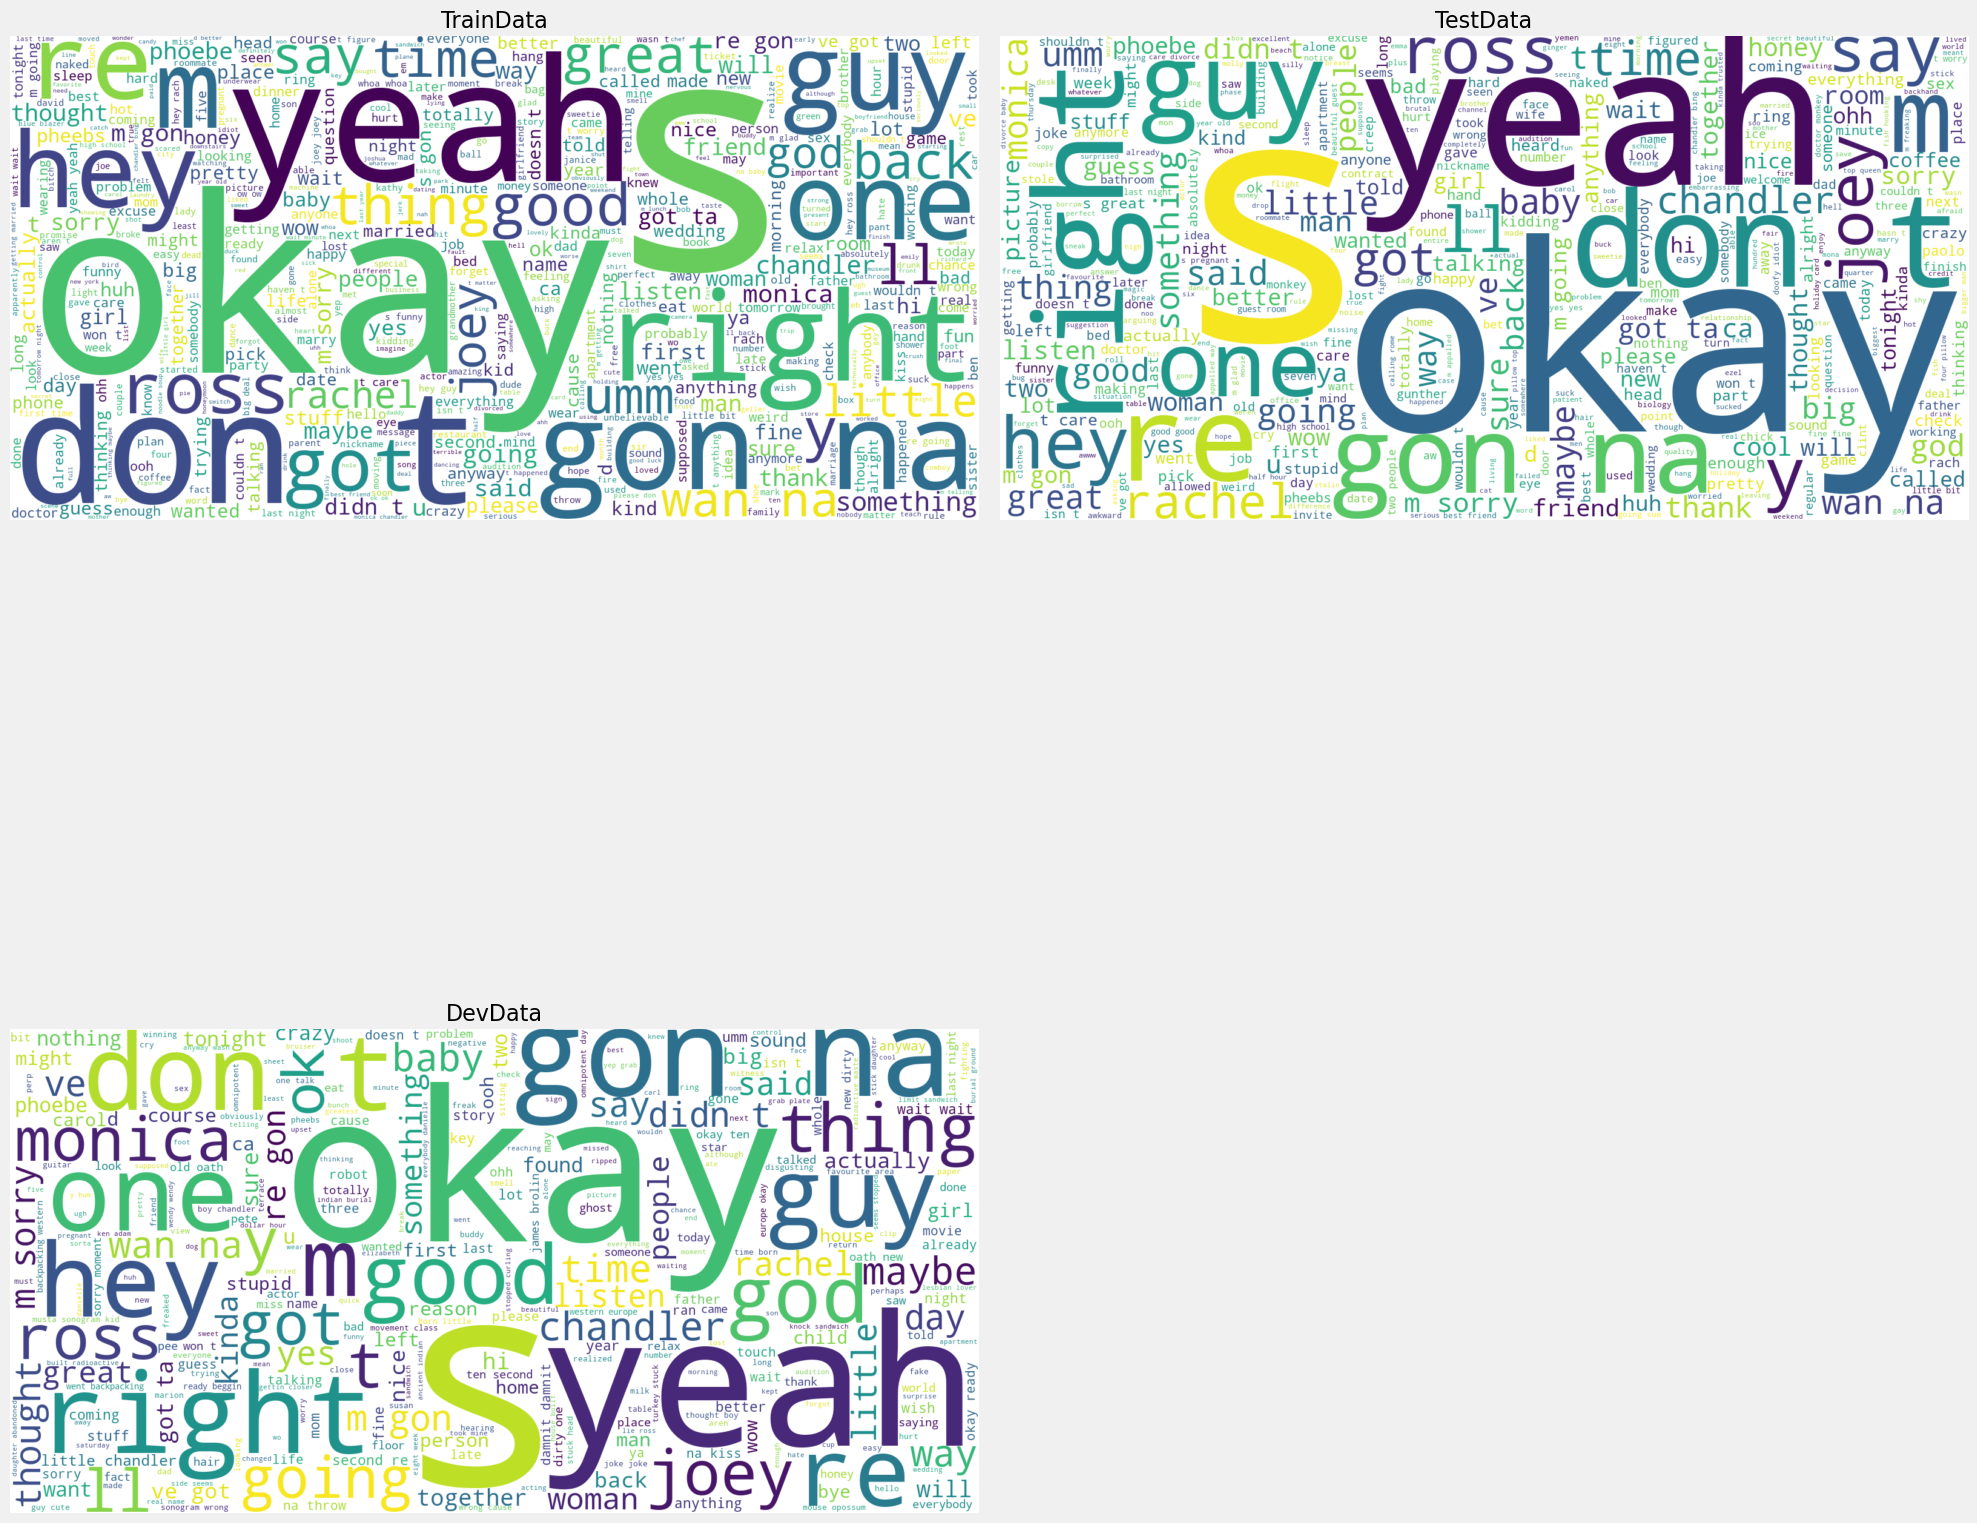

In [203]:
# WORD CLOUDS
# Function to get the top 10 words from a word cloud
def get_top_words(wordcloud):
    word_freq = wordcloud.words_
    top_words = [word for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]]
    return top_words

# Corrected WordCloud generation for all datasets
WC_Train = WordCloud(
    max_words=2000, min_font_size=10, height=800, width=1600, background_color="white"
).generate(" ".join(TrainData.Utterance))

WC_Test = WordCloud(
    max_words=2000, min_font_size=10, height=800, width=1600, background_color="white"
).generate(" ".join(TestData.Utterance))

WC_Dev = WordCloud(
    max_words=2000, min_font_size=10, height=800, width=1600, background_color="white"
).generate(" ".join(DevData.Utterance))

# Get top 10 words for each dataset
top_words_train = get_top_words(WC_Train)
top_words_test = get_top_words(WC_Test)
top_words_dev = get_top_words(WC_Dev)

# Print the top words
print("Top words in TrainData:", top_words_train)
print("Top words in TestData:", top_words_test)
print("Top words in DevData:", top_words_dev)

# PLOT
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))  # Adjust the layout and size as needed
axes = axes.flatten()  # Flatten the 2D array to 1D for easier indexing

wordclouds = [WC_Train, WC_Test, WC_Dev]
titles = ['TrainData', 'TestData', 'DevData']

# Plot each WordCloud
for idx, wc in enumerate(wordclouds):
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].set_title(titles[idx], fontsize=16)
    axes[idx].axis('off')

# Remove any empty subplots (if applicable)
for idx in range(len(wordclouds), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

### Division of X and y data

In [204]:
# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()
y_dev = pd.DataFrame()

X_train = TrainData
X_test = TestData
X_dev = DevData
    
y_train["Emotion"] = TrainData["Emotion"].copy()
y_test["Emotion"] = TestData["Emotion"].copy()
y_dev["Emotion"] = DevData["Emotion"].copy()

y_train["Dialogue_ID"] = TrainData["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = TestData["Dialogue_ID"].copy()
y_dev["Dialogue_ID"] = DevData["Dialogue_ID"].copy()

In [205]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('--')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')
print('--')
print(f'Shape of X_dev: {X_dev.shape}')
print(f'Shape of y_dev: {y_dev.shape}')

Shape of X_train: (7359, 6)
Shape of y_train: (7359, 2)
--
Shape of X_test: (1981, 6)
Shape of y_test: (1981, 2)
--
Shape of X_dev: (858, 6)
Shape of y_dev: (858, 2)


### Output data to new csv

##### Label Encoding Data

In [206]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/labels_test.pkl")

if key:
    pickle.dump(X_train["Emotion"], open('data/dump/' + dataset_path + '/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/' + dataset_path + '/labels_test.pkl', 'wb'))

##### Drop Noise Training and Testing Data

In [207]:
def exportDataToCSV(df, name):
    path = "data/" + dataset_path + "/" + name + ".csv"
    df.to_csv(path)


In [208]:
exportDataToCSV(X_train, "X_train")
exportDataToCSV(y_train, "y_train")

exportDataToCSV(X_test, "X_test")
exportDataToCSV(y_test, "y_test")

exportDataToCSV(X_dev, "X_dev")
exportDataToCSV(y_dev, "y_dev")

##### Original Training and Testing Data

In [209]:
dataset_path = "dataset_original"

In [210]:
exportDataToCSV(TrainData_Original, "X_train")
exportDataToCSV(TrainData_Original['Emotion'], "y_train")

exportDataToCSV(TestData_Original, "X_test")
exportDataToCSV(TestData_Original['Emotion'], "y_test")

exportDataToCSV(DevData_Original, "X_dev")
exportDataToCSV(DevData_Original['Emotion'], "y_dev")